## Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
import random

import seaborn as sn
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy.stats import norm
from scipy.stats import linregress
import itertools
from scipy.optimize import minimize

# Assignment 6

In [ ]:
My_Portfolio_X = pd.read_csv('My_Portfolio_X.csv')

### Intermediate Functions

In [88]:
def get_risk_free_rate():
    # download 10-year us treasury bills rates
    annualized = yf.download("^TNX")["Adj Close"]

    # create dataframe
    return pd.DataFrame({"annualized": annualized})

if __name__ == "__main__":
    rates = get_risk_free_rate()
    Risk_Free_Return_Percentage = np.round((rates["annualized"].iloc[-1]), 4)

Risk_Free_Return = (Risk_Free_Return_Percentage / 100)
Risk_Free_Return

[*********************100%%**********************]  1 of 1 completed


0.04595

In [89]:
Risk_Free_Return = 0.0
risk_free_rate = 0.0

In [90]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate):
    annualized_std = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year
    portfolio_return = np.mean(daily_returns) * 252
    sharpe_ratio = (portfolio_return - risk_free_rate) / annualized_std
    return sharpe_ratio

In [91]:
def calculate_beta(df, benchmark_column, portfolio_column):
    # Calculate the covariance between the portfolio and the benchmark returns
    covariance = df[portfolio_column].cov(df[benchmark_column])

    # Calculate the variance of the benchmark returns
    benchmark_variance = df[benchmark_column].var()

    # Ensure that both covariance and benchmark_variance are not series
    if isinstance(covariance, pd.Series) or isinstance(benchmark_variance, pd.Series):
        raise TypeError("Covariance or Variance calculation did not return a single value as expected.")

    # Calculate beta as the ratio of covariance to variance
    beta = covariance / benchmark_variance
    return beta

In [92]:
def calculate_volatility(daily_returns):
    annualized_std = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year
    return annualized_std

In [93]:
def calculate_max_drawdown(portfolio_returns):
    # Calculate the cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    # Calculate the previous peaks
    previous_peaks = cumulative_returns.cummax()
    # Calculate the drawdowns
    drawdowns = (cumulative_returns - previous_peaks) / previous_peaks
    # Find the maximum drawdown
    max_drawdown = drawdowns.min()
    return max_drawdown

### Determining Allocation in SAA

In [94]:
My_Portfolio_X

,Unnamed: 0,Dates,SPX Index,LBUSTRUU Index,SPGSCI Index,RMSG Index,LP01TREU Index,TWSE Index,IBOV Index,SASEIDX Index,...,SPGSCI Index Daily Returns,RMSG Index Daily Returns,LP01TREU Index Daily Returns,TWSE Index Daily Returns,IBOV Index Daily Returns,SASEIDX Index Daily Returns,NKY Index Daily Returns,MXDK Index Daily Returns,SMI Index Daily Returns,VNINDEX Index Daily Returns
0,1,2000-07-31,100.803816,100.058935,108.575287,100.992780,97.576345,99.750371,100.539839,103.521739,...,0.085753,0.009928,-0.024237,-0.002496,0.005398,0.035217,-0.008029,0.027378,0.010515,0.015500
1,2,2000-08-01,101.337560,100.269629,103.241053,104.912326,98.351915,97.939848,98.642616,102.565217,...,-0.049129,0.038810,0.007948,-0.018151,-0.018870,-0.009240,0.032239,0.012870,0.000000,0.000000
2,3,2000-08-02,101.389612,100.405180,94.800810,104.306343,99.369850,97.084583,98.240332,103.521739,...,-0.081753,-0.005776,0.010350,-0.008733,-0.004078,0.009326,0.014166,-0.016340,0.004038,0.017824
3,4,2000-08-03,102.417848,100.564306,91.627279,102.372357,99.175957,96.200952,100.695562,103.608696,...,-0.033476,-0.018541,-0.001951,-0.009102,0.024992,0.000840,-0.025252,-0.018195,-0.015645,0.000000
4,5,2000-08-04,103.192225,100.866349,79.675895,99.716349,99.660688,97.373217,101.676616,103.608696,...,-0.130435,-0.025945,0.004888,0.012186,0.009743,0.000000,-0.012042,0.019680,-0.002380,0.017415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5212,5213,2020-07-22,351.613178,298.676902,-237.677245,1141.761217,1500.678623,335.766511,253.732157,2349.869565,...,0.005140,0.022681,-0.000097,0.008383,0.021888,0.001649,-0.010962,-0.001303,0.003513,-0.008141
5213,5214,2020-07-23,347.255335,298.946531,-232.343011,1133.767406,1505.622879,334.973654,244.103296,2349.347826,...,-0.022443,-0.007001,0.003295,-0.002361,-0.037949,-0.000222,0.000000,-0.000478,-0.000406,0.002681
5214,5215,2020-07-24,345.086653,298.816873,-233.288319,1123.891181,1505.671352,331.663227,242.535686,2349.347826,...,0.004069,-0.008711,0.000032,-0.009883,-0.006422,0.000000,0.000000,-0.015103,-0.014501,-0.032076
5215,5216,2020-07-27,347.671750,298.604706,-234.706280,1134.902011,1505.235095,340.691729,249.566572,2360.086957,...,0.006078,0.009797,-0.000290,0.027222,0.028989,0.004571,0.017999,0.013193,0.008145,-0.053580


In [95]:
My_Portfolio_X.columns

Index(['Unnamed: 0', 'Dates', 'SPX Index', 'LBUSTRUU Index', 'SPGSCI Index',
       'RMSG Index', 'LP01TREU Index', 'TWSE Index', 'IBOV Index',
       'SASEIDX Index', 'NKY Index', 'MXDK Index', 'SMI Index',
       'VNINDEX Index', 'SPX Index Daily Returns',
       'LBUSTRUU Index Daily Returns', 'SPGSCI Index Daily Returns',
       'RMSG Index Daily Returns', 'LP01TREU Index Daily Returns',
       'TWSE Index Daily Returns', 'IBOV Index Daily Returns',
       'SASEIDX Index Daily Returns', 'NKY Index Daily Returns',
       'MXDK Index Daily Returns', 'SMI Index Daily Returns',
       'VNINDEX Index Daily Returns'],
      dtype='object')

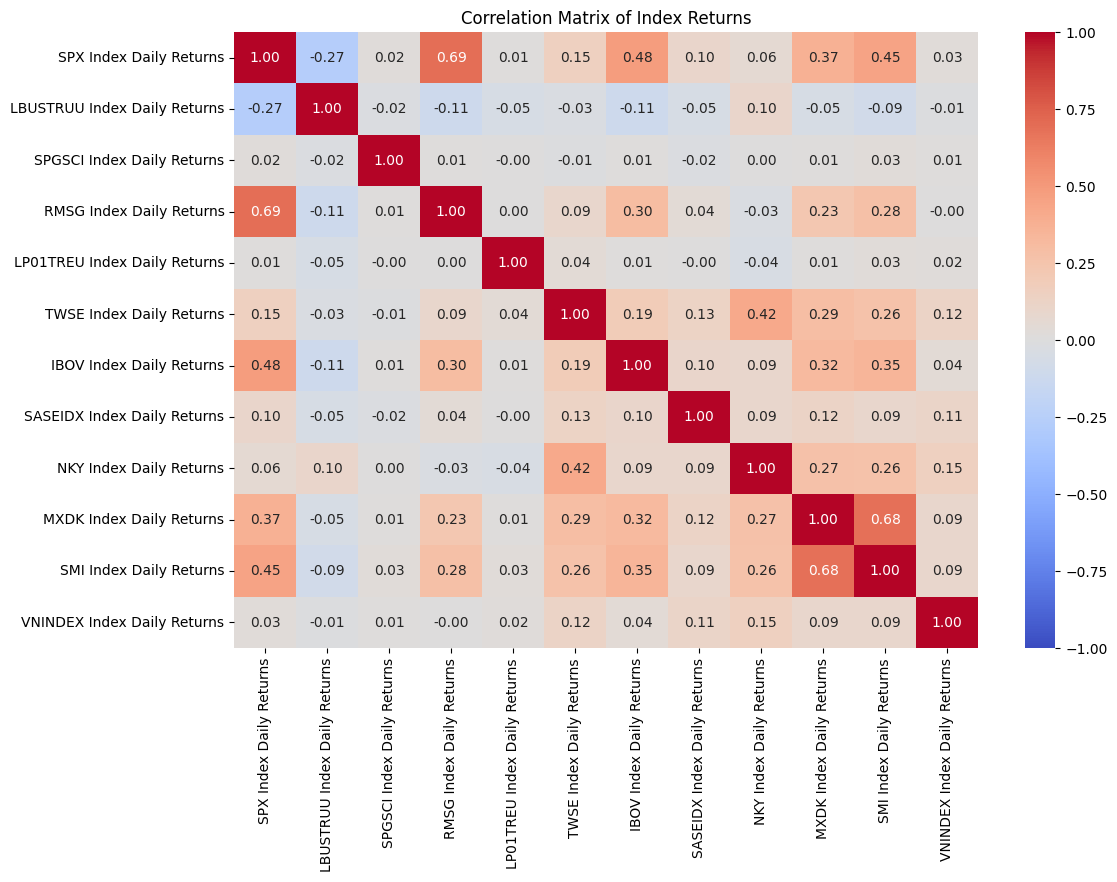

In [96]:
correlation_matrix = My_Portfolio_X[['SPX Index Daily Returns', 'LBUSTRUU Index Daily Returns', 'SPGSCI Index Daily Returns', 'RMSG Index Daily Returns',
                                     'LP01TREU Index Daily Returns', 'TWSE Index Daily Returns', 'IBOV Index Daily Returns', 'SASEIDX Index Daily Returns',
                                     'NKY Index Daily Returns', 'MXDK Index Daily Returns', 'SMI Index Daily Returns', 'VNINDEX Index Daily Returns']].corr()

correlation_matrix = correlation_matrix.round(2)

plt.figure(figsize=(12, 8))

sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

plt.title("Correlation Matrix of Index Returns")
plt.show()

In [97]:
# Function to calculate portfolio metrics
def calculate_metrics(weights, daily_returns, risk_free_rate=0):
    portfolio_return = np.dot(daily_returns.mean(), weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

# Objective function to maximize Sharpe ratio
def objective_function(weights, daily_returns, risk_free_rate=0):
    portfolio_return, portfolio_std, sharpe_ratio = calculate_metrics(weights, daily_returns, risk_free_rate)
    return -sharpe_ratio  # Minimize negative Sharpe ratio to maximize

In [98]:
# Define the indexes and their respective daily return columns
myIndexes = ['SPX Index', 'LBUSTRUU Index', 'SPGSCI Index', 'RMSG Index',
             'LP01TREU Index', 'TWSE Index', 'IBOV Index', 'SASEIDX Index',
             'NKY Index', 'MXDK Index', 'SMI Index', 'VNINDEX Index']

# Targets
min_target_return = 0.11
max_target_volatility = 0.09

In [99]:
# Setup initial weights
num_indexes = len(myIndexes)
init_weights = [1 / num_indexes] * num_indexes

# Constraints
constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'ineq', 'fun': lambda x: calculate_metrics(x, My_Portfolio_X[myIndexes].pct_change().dropna())[0] * 252 - min_target_return},
    {'type': 'ineq', 'fun': lambda x: calculate_metrics(x, My_Portfolio_X[myIndexes].pct_change().dropna())[1] - max_target_volatility},
    {'type': 'ineq', 'fun': lambda x: x[myIndexes.index('SPX Index')] - 0.08},
    {'type': 'ineq', 'fun': lambda x: 0.3 - x}
)

# Bounds
bounds = tuple((0, 1) for _ in range(num_indexes))

In [100]:
# Optimize
optimal_weights = minimize(objective_function, init_weights, args=(My_Portfolio_X[myIndexes].pct_change().dropna(), risk_free_rate),
                           method='SLSQP', bounds=bounds, constraints=constraints)

# Create DataFrame for results
optimal_allocation = pd.DataFrame(index=myIndexes)
optimal_allocation['Optimal Weights'] = optimal_weights.x
optimal_allocation['Optimal Weights'] = optimal_allocation['Optimal Weights'].apply(lambda x: round(x, 4))

In [101]:
# Calculate portfolio metrics
portfolio_return, portfolio_std, sharpe_ratio = calculate_metrics(optimal_weights.x, My_Portfolio_X[myIndexes].pct_change().dropna(), risk_free_rate)

print("Optimal Weights:")
print(optimal_allocation)
print("\nPortfolio Return: {:.2f}%".format(portfolio_return * 100))
print("Portfolio Volatility: {:.2f}%".format(portfolio_std * 100))
print("Sharpe Ratio: {:.4f}".format(sharpe_ratio))

Optimal Weights:
                Optimal Weights
SPX Index                0.0800
LBUSTRUU Index           0.3000
SPGSCI Index             0.0009
RMSG Index               0.0604
LP01TREU Index           0.0000
TWSE Index               0.0587
IBOV Index               0.0001
SASEIDX Index            0.1466
NKY Index                0.0129
MXDK Index               0.1454
SMI Index                0.0000
VNINDEX Index            0.1951

Portfolio Return: 11.90%
Portfolio Volatility: 10.29%
Sharpe Ratio: 1.1568


In [102]:
SAA_Portfolio_Allocation = {'Index': ["SPX", "LBUSTRUU", "SPGSCI", "RMSG", "TWSE", "IBOV", "SASEIDX", "NYK", "MXDK", "VNINDEX"],
                            'Allocation': [0.08, 0.3, 0.0009, 0.0604, 0.0587, 0.0001, 0.1466, 0.0129, 0.1454, 0.1951]}

In [103]:
SAA_Portfolio_Allocation = pd.DataFrame(SAA_Portfolio_Allocation)

In [104]:
SAA_Portfolio_Allocation

,Index,Allocation
0,SPX,0.0800
1,LBUSTRUU,0.3000
2,SPGSCI,0.0009
3,RMSG,0.0604
4,TWSE,0.0587
5,IBOV,0.0001
6,SASEIDX,0.1466
7,NYK,0.0129
8,MXDK,0.1454
9,VNINDEX,0.1951


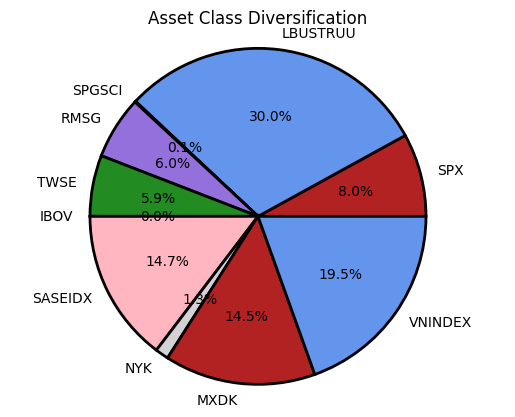

In [105]:
plt.pie(SAA_Portfolio_Allocation['Allocation'], labels=SAA_Portfolio_Allocation['Index'], autopct='%1.001f%%',
        colors = ['firebrick', 'cornflowerblue','yellowgreen', 'mediumpurple', 'forestgreen', 'thistle', 'lightpink', 'lightgrey'],
        wedgeprops={"edgecolor": "black", 'linewidth': 2, 'antialiased': True})
plt.title('Asset Class Diversification')
plt.axis('equal')

plt.show()

### Creating Ray Dalio Portfolio Using ETFs

In [106]:
My_Portfolio_Z = pd.read_csv('Ray_Dalio_ETFs_Data.csv')

In [107]:
My_Portfolio_Z

,Date,VTI US Equity,TLT US Equity,IEI US Equity,DBC US Equity,GLD US Equity
0,7/28/2020,162.890,170.28,133.79,12.95,183.75
1,7/27/2020,164.090,169.11,133.64,13.02,182.23
2,7/24/2020,162.690,169.74,133.74,12.90,178.70
3,7/23/2020,163.960,169.75,133.72,12.88,177.18
4,7/22/2020,165.770,167.79,133.72,12.91,175.63
...,...,...,...,...,...,...
4815,6/6/2001,58.420,NaN,NaN,NaN,NaN
4816,6/5/2001,58.905,NaN,NaN,NaN,NaN
4817,6/4/2001,58.025,NaN,NaN,NaN,NaN
4818,6/1/2001,57.785,NaN,NaN,NaN,NaN


In [108]:
My_Portfolio_Z.fillna(method='ffill', inplace=True)

In [109]:
My_Portfolio_Z = My_Portfolio_Z.drop_duplicates()

In [110]:
print(My_Portfolio_Z.isnull().sum())

Date             0
VTI US Equity    0
TLT US Equity    0
IEI US Equity    0
DBC US Equity    0
GLD US Equity    0
dtype: int64


In [111]:
My_Portfolio_Z = My_Portfolio_Z.rename(columns = {"Date" : "Dates"})

In [112]:
My_Portfolio_Z

,Dates,VTI US Equity,TLT US Equity,IEI US Equity,DBC US Equity,GLD US Equity
0,7/28/2020,162.890,170.28,133.79,12.95,183.75
1,7/27/2020,164.090,169.11,133.64,13.02,182.23
2,7/24/2020,162.690,169.74,133.74,12.90,178.70
3,7/23/2020,163.960,169.75,133.72,12.88,177.18
4,7/22/2020,165.770,167.79,133.72,12.91,175.63
...,...,...,...,...,...,...
4815,6/6/2001,58.420,82.51,99.92,24.50,44.38
4816,6/5/2001,58.905,82.51,99.92,24.50,44.38
4817,6/4/2001,58.025,82.51,99.92,24.50,44.38
4818,6/1/2001,57.785,82.51,99.92,24.50,44.38


In [113]:
My_Portfolio_Z.columns

Index(['Dates', 'VTI US Equity', 'TLT US Equity', 'IEI US Equity',
       'DBC US Equity', 'GLD US Equity'],
      dtype='object')

In [114]:
myIndexes = ['VTI US Equity', 'TLT US Equity', 'IEI US Equity',
             'DBC US Equity', 'GLD US Equity']

In [115]:
# Make sure 'Date' column is in datetime format
My_Portfolio_Z['Dates'] = pd.to_datetime(My_Portfolio_Z['Dates'])

# Sort dataframe by date in descending order
My_Portfolio_Z.sort_values(by='Dates', ascending=True, inplace=True)

In [116]:
My_Portfolio_Z

,Dates,VTI US Equity,TLT US Equity,IEI US Equity,DBC US Equity,GLD US Equity
4819,2001-05-31,57.400,82.51,99.92,24.50,44.38
4818,2001-06-01,57.785,82.51,99.92,24.50,44.38
4817,2001-06-04,58.025,82.51,99.92,24.50,44.38
4816,2001-06-05,58.905,82.51,99.92,24.50,44.38
4815,2001-06-06,58.420,82.51,99.92,24.50,44.38
...,...,...,...,...,...,...
4,2020-07-22,165.770,167.79,133.72,12.91,175.63
3,2020-07-23,163.960,169.75,133.72,12.88,177.18
2,2020-07-24,162.690,169.74,133.74,12.90,178.70
1,2020-07-27,164.090,169.11,133.64,13.02,182.23


In [117]:
# Set initial investment to 100 for each index
initial_investment = 100

for index in myIndexes:
    My_Portfolio_Z[index] = My_Portfolio_Z[index] / My_Portfolio_Z.iloc[0][index]  * initial_investment

# Check the updated dataframe
My_Portfolio_Z

,Dates,VTI US Equity,TLT US Equity,IEI US Equity,DBC US Equity,GLD US Equity
4819,2001-05-31,100.000000,100.000000,100.000000,100.000000,100.000000
4818,2001-06-01,100.670732,100.000000,100.000000,100.000000,100.000000
4817,2001-06-04,101.088850,100.000000,100.000000,100.000000,100.000000
4816,2001-06-05,102.621951,100.000000,100.000000,100.000000,100.000000
4815,2001-06-06,101.777003,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...
4,2020-07-22,288.797909,203.357169,133.827062,52.693878,395.741325
3,2020-07-23,285.644599,205.732638,133.827062,52.571429,399.233889
2,2020-07-24,283.432056,205.720519,133.847078,52.653061,402.658855
1,2020-07-27,285.871080,204.956975,133.746998,53.142857,410.612889


In [118]:
# Calculate daily returns
for index in myIndexes:
  My_Portfolio_Z[index + " Daily Returns"] = My_Portfolio_Z[index].pct_change()

# Check the updated dataframe
My_Portfolio_Z

,Dates,VTI US Equity,TLT US Equity,IEI US Equity,DBC US Equity,GLD US Equity,VTI US Equity Daily Returns,TLT US Equity Daily Returns,IEI US Equity Daily Returns,DBC US Equity Daily Returns,GLD US Equity Daily Returns
4819,2001-05-31,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN
4818,2001-06-01,100.670732,100.000000,100.000000,100.000000,100.000000,0.006707,0.000000,0.000000,0.000000,0.000000
4817,2001-06-04,101.088850,100.000000,100.000000,100.000000,100.000000,0.004153,0.000000,0.000000,0.000000,0.000000
4816,2001-06-05,102.621951,100.000000,100.000000,100.000000,100.000000,0.015166,0.000000,0.000000,0.000000,0.000000
4815,2001-06-06,101.777003,100.000000,100.000000,100.000000,100.000000,-0.008234,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
4,2020-07-22,288.797909,203.357169,133.827062,52.693878,395.741325,0.005215,0.002989,-0.000075,0.006235,0.015202
3,2020-07-23,285.644599,205.732638,133.827062,52.571429,399.233889,-0.010919,0.011681,0.000000,-0.002324,0.008825
2,2020-07-24,283.432056,205.720519,133.847078,52.653061,402.658855,-0.007746,-0.000059,0.000150,0.001553,0.008579
1,2020-07-27,285.871080,204.956975,133.746998,53.142857,410.612889,0.008605,-0.003712,-0.000748,0.009302,0.019754


In [119]:
My_Portfolio_Z.columns

Index(['Dates', 'VTI US Equity', 'TLT US Equity', 'IEI US Equity',
       'DBC US Equity', 'GLD US Equity', 'VTI US Equity Daily Returns',
       'TLT US Equity Daily Returns', 'IEI US Equity Daily Returns',
       'DBC US Equity Daily Returns', 'GLD US Equity Daily Returns'],
      dtype='object')

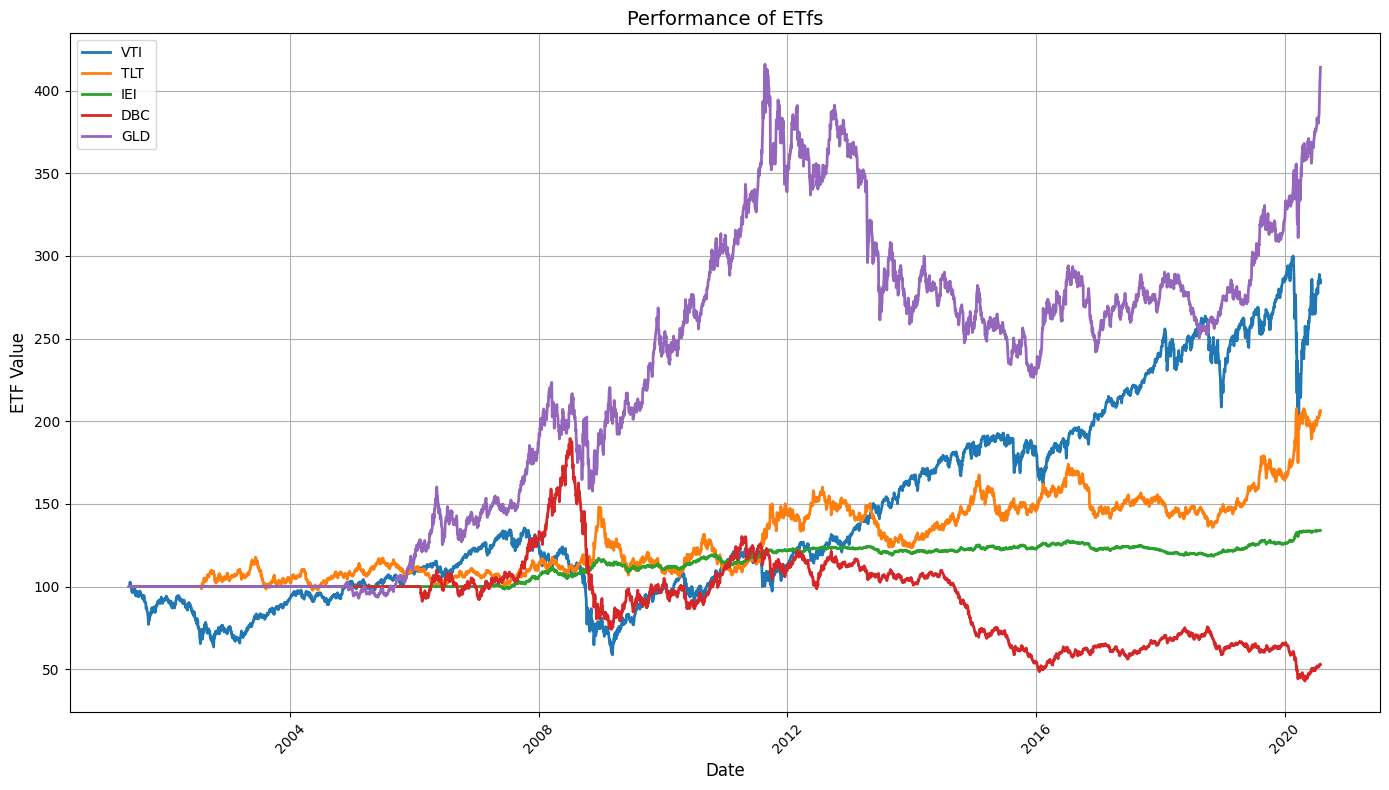

In [120]:
# Define the x-axis (dates)
dates = My_Portfolio_Z['Dates']

# Plotting
plt.figure(figsize=(14, 8))

for index in myIndexes:
    plt.plot(dates, My_Portfolio_Z[index], label=index.split()[0], linewidth=2)

# Adding labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('ETF Value', fontsize=12)
plt.title('Performance of ETfs', fontsize=14)
plt.legend(fontsize=10, loc='upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [121]:
Ray_Dalio_Portfolio_Allocation = {'Index': ['VTI', 'TLT', 'IEI', 'DBC', 'GLD'],
                                  'Allocation': [0.3, 0.4, 0.15, 0.075, 0.075]}

In [122]:
Ray_Dalio_Portfolio_Allocation = pd.DataFrame(Ray_Dalio_Portfolio_Allocation)

In [123]:
Ray_Dalio_Portfolio_Allocation

,Index,Allocation
0,VTI,0.300
1,TLT,0.400
2,IEI,0.150
3,DBC,0.075
4,GLD,0.075


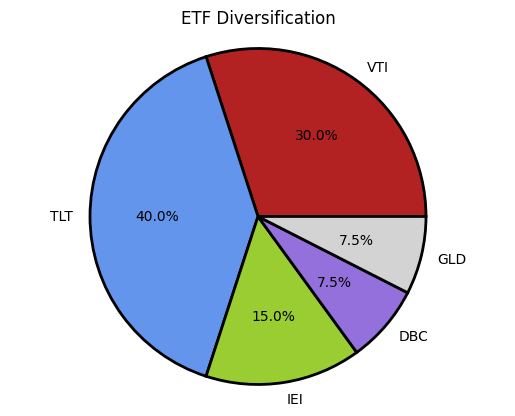

In [124]:
plt.pie(Ray_Dalio_Portfolio_Allocation['Allocation'], labels=Ray_Dalio_Portfolio_Allocation['Index'], autopct='%1.001f%%',
        colors = ['firebrick', 'cornflowerblue','yellowgreen', 'mediumpurple', 'lightgrey'],
        wedgeprops={"edgecolor": "black", 'linewidth': 2, 'antialiased': True})
plt.title('ETF Diversification')
plt.axis('equal')

plt.show()

### Gauging Portfolio Performances

In [125]:
Complete_Portfolio_Performance = pd.read_csv("Complete_Portfolio_Performance.csv")

In [126]:
Complete_Portfolio_Performance

,Unnamed: 0,Date,Pure SPX Portfolio Value,Pure SPX Daily Return,Rebalanced 60/40 Portfolio Value,Rebalanced 60/40 Daily Return,Rebalanced Equal Weighted SAA Portfolio Value,Rebalanced Equal Weighted SAA Daily Return,Rebalanced SAA Portfolio Value,Rebalanced SAA Daily Return,Rebalanced Ray Dalio Portfolio Value,Rebalanced Ray Dalio Portfolio Daily Return
0,0,2001-05-31,88.908278,0.006589,98.020575,0.006351,107.520187,0.001626,131.545187,0.001169,100.000000,NaN
1,1,2001-06-01,89.267947,0.004045,98.345674,0.003317,107.774665,0.002367,132.161317,0.004684,100.100610,0.001006
2,2,2001-06-04,89.747506,0.005372,98.740739,0.004017,108.060242,0.002650,132.795326,0.004797,100.163328,0.000627
3,3,2001-06-05,90.969870,0.013620,99.682691,0.009540,108.322289,0.002425,133.153480,0.002697,100.393293,0.002296
4,4,2001-06-06,89.977473,-0.010909,99.039718,-0.006450,108.892729,0.005266,133.892290,0.005549,100.266551,-0.001262
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4994,2020-07-22,351.613178,0.005843,358.503480,0.004010,399.132636,0.003132,469.718359,0.001118,160.844470,0.003617
4995,4995,2020-07-23,347.255335,-0.012394,355.900984,-0.007259,398.664494,-0.001173,469.459935,-0.000550,160.972947,0.000799
4996,4996,2020-07-24,345.086653,-0.006245,354.483562,-0.003983,396.002916,-0.006676,465.477858,-0.008482,160.771640,-0.001251
4997,4997,2020-07-27,347.671750,0.007491,356.003172,0.004287,396.689589,0.001734,463.779462,-0.003649,161.293922,0.003249


In [127]:
print(Complete_Portfolio_Performance.isnull().sum())

Unnamed: 0                                       0
Date                                             0
Pure SPX Portfolio Value                         0
Pure SPX Daily Return                            0
Rebalanced 60/40 Portfolio Value                 0
Rebalanced 60/40 Daily Return                    0
Rebalanced Equal Weighted SAA Portfolio Value    0
Rebalanced Equal Weighted SAA Daily Return       0
Rebalanced SAA Portfolio Value                   0
Rebalanced SAA Daily Return                      0
Rebalanced Ray Dalio Portfolio Value             0
Rebalanced Ray Dalio Portfolio Daily Return      1
dtype: int64


In [128]:
Complete_Portfolio_Performance.fillna(method='ffill', inplace=True)

In [129]:
Complete_Portfolio_Performance

,Unnamed: 0,Date,Pure SPX Portfolio Value,Pure SPX Daily Return,Rebalanced 60/40 Portfolio Value,Rebalanced 60/40 Daily Return,Rebalanced Equal Weighted SAA Portfolio Value,Rebalanced Equal Weighted SAA Daily Return,Rebalanced SAA Portfolio Value,Rebalanced SAA Daily Return,Rebalanced Ray Dalio Portfolio Value,Rebalanced Ray Dalio Portfolio Daily Return
0,0,2001-05-31,88.908278,0.006589,98.020575,0.006351,107.520187,0.001626,131.545187,0.001169,100.000000,NaN
1,1,2001-06-01,89.267947,0.004045,98.345674,0.003317,107.774665,0.002367,132.161317,0.004684,100.100610,0.001006
2,2,2001-06-04,89.747506,0.005372,98.740739,0.004017,108.060242,0.002650,132.795326,0.004797,100.163328,0.000627
3,3,2001-06-05,90.969870,0.013620,99.682691,0.009540,108.322289,0.002425,133.153480,0.002697,100.393293,0.002296
4,4,2001-06-06,89.977473,-0.010909,99.039718,-0.006450,108.892729,0.005266,133.892290,0.005549,100.266551,-0.001262
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,4994,2020-07-22,351.613178,0.005843,358.503480,0.004010,399.132636,0.003132,469.718359,0.001118,160.844470,0.003617
4995,4995,2020-07-23,347.255335,-0.012394,355.900984,-0.007259,398.664494,-0.001173,469.459935,-0.000550,160.972947,0.000799
4996,4996,2020-07-24,345.086653,-0.006245,354.483562,-0.003983,396.002916,-0.006676,465.477858,-0.008482,160.771640,-0.001251
4997,4997,2020-07-27,347.671750,0.007491,356.003172,0.004287,396.689589,0.001734,463.779462,-0.003649,161.293922,0.003249


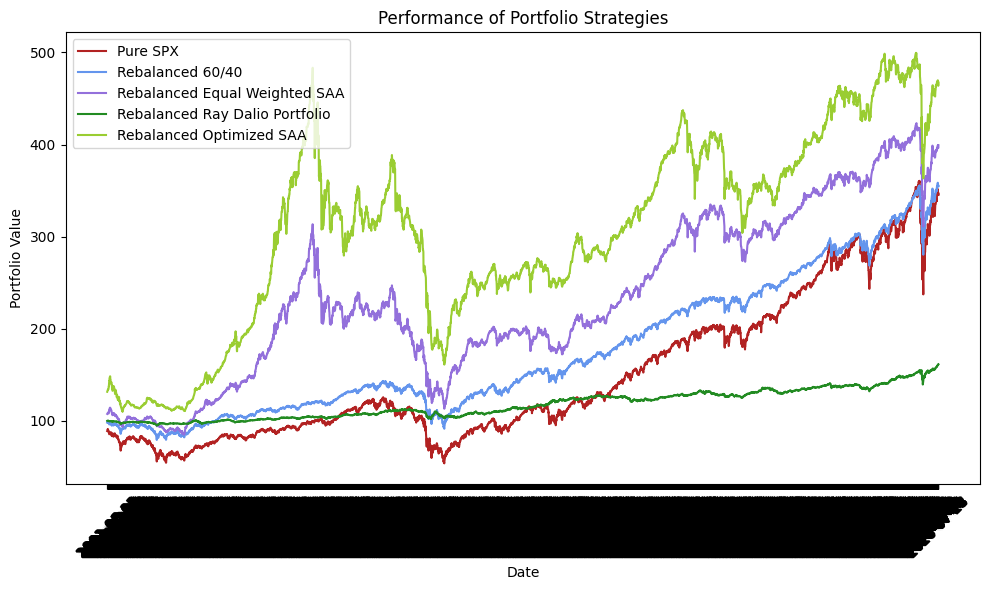

In [130]:
# Define the x-axis (dates)
dates = Complete_Portfolio_Performance['Date']

# Define the y-axis (portfolio values)
pure_spx = Complete_Portfolio_Performance['Pure SPX Portfolio Value']
rebalanced_60_40 = Complete_Portfolio_Performance['Rebalanced 60/40 Portfolio Value']
rebalanced_ew_saa = Complete_Portfolio_Performance['Rebalanced Equal Weighted SAA Portfolio Value']
rebalanced_ray_dalio_portfolio = Complete_Portfolio_Performance['Rebalanced Ray Dalio Portfolio Value']
rebalanced_saa = Complete_Portfolio_Performance['Rebalanced SAA Portfolio Value']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, pure_spx, label='Pure SPX', color='firebrick')
plt.plot(dates, rebalanced_60_40, label='Rebalanced 60/40', color='cornflowerblue')
plt.plot(dates, rebalanced_ew_saa, label='Rebalanced Equal Weighted SAA', color='mediumpurple')
plt.plot(dates, rebalanced_ray_dalio_portfolio, label='Rebalanced Ray Dalio Portfolio', color='forestgreen')
plt.plot(dates, rebalanced_saa, label='Rebalanced Optimized SAA', color='yellowgreen')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Performance of Portfolio Strategies')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [131]:
# Ensure the 'Date' column is in datetime format
Complete_Portfolio_Performance['Date'] = pd.to_datetime(Complete_Portfolio_Performance['Date'])

# Find the last date in the 'Date' column
last_date = Complete_Portfolio_Performance['Date'].iloc[-1]

# Define the periods
periods = {
    "Current": last_date,
    '1yr': last_date - relativedelta(years=1),
    '3yr': last_date - relativedelta(years=3),
    '5yr': last_date - relativedelta(years=5),
    '10yr': last_date - relativedelta(years=10),
    '20yr': last_date - relativedelta(years=20)
}

In [132]:
def find_next_trading_day(df, target_date):
    future_dates = df[df['Date'] >= target_date]
    if not future_dates.empty:
        return future_dates.iloc[0].name
    else:
        return None

In [133]:
# Extract indices for 1yr, 3yr, and 5yr periods
indices = []
for period in periods.values():
    # Try to get the index for the exact date
    exact_date_index = Complete_Portfolio_Performance.index[Complete_Portfolio_Performance['Date'] == period]
    if not exact_date_index.empty:
        indices.append(exact_date_index[0])
    else:
        # If the exact date is not present, find the next trading day
        next_date_index = find_next_trading_day(Complete_Portfolio_Performance, period)
        if next_date_index is not None:
            indices.append(next_date_index)

# Use the indices to select the rows from the original DataFrame
selected_rows = Complete_Portfolio_Performance.loc[indices]

# This is your new DataFrame with the selected rows
portfolio_values = pd.DataFrame(selected_rows)
portfolio_values['Period'] = ["Current",
                              "1 Year",
                              "3 Year",
                              "5 Year",
                              "10 Year",
                              "20 Year"]
portfolio_values

,Unnamed: 0,Date,Pure SPX Portfolio Value,Pure SPX Daily Return,Rebalanced 60/40 Portfolio Value,Rebalanced 60/40 Daily Return,Rebalanced Equal Weighted SAA Portfolio Value,Rebalanced Equal Weighted SAA Daily Return,Rebalanced SAA Portfolio Value,Rebalanced SAA Daily Return,Rebalanced Ray Dalio Portfolio Value,Rebalanced Ray Dalio Portfolio Daily Return,Period
4998,4998,2020-07-28,345.397684,-0.006541,354.763593,-0.003482,399.143686,0.006186,467.297221,0.007585,161.392916,0.000614,Current
4737,4737,2019-07-29,317.577288,-0.001634,323.305154,-0.000432,405.299722,-0.002592,489.248022,-0.003100,145.283560,0.000008,1 Year
4216,4216,2017-07-28,248.959391,-0.001325,270.654053,-0.000236,343.304463,-0.000827,400.685589,0.001317,134.969580,0.001639,3 Year
3693,3693,2015-07-28,201.169032,0.012659,232.051842,0.007298,329.366695,0.000428,404.367261,0.000777,128.193685,0.001104,5 Year
2389,2389,2010-07-28,93.459822,-0.007170,134.147249,-0.003500,195.184823,-0.000889,254.451830,-0.002675,110.455149,0.000380,10 Year
0,0,2001-05-31,88.908278,0.006589,98.020575,0.006351,107.520187,0.001626,131.545187,0.001169,100.000000,NaN,20 Year


In [134]:
portfolio_values.columns

Index(['Unnamed: 0', 'Date', 'Pure SPX Portfolio Value',
       'Pure SPX Daily Return', 'Rebalanced 60/40 Portfolio Value',
       'Rebalanced 60/40 Daily Return',
       'Rebalanced Equal Weighted SAA Portfolio Value',
       'Rebalanced Equal Weighted SAA Daily Return',
       'Rebalanced SAA Portfolio Value', 'Rebalanced SAA Daily Return',
       'Rebalanced Ray Dalio Portfolio Value',
       'Rebalanced Ray Dalio Portfolio Daily Return', 'Period'],
      dtype='object')

In [135]:
def get_risk_free_rate():
    # download 10-year us treasury bills rates
    annualized = yf.download("^TNX")["Adj Close"]

    # create dataframe
    return pd.DataFrame({"annualized": annualized})

if __name__ == "__main__":
    rates = get_risk_free_rate()
    Risk_Free_Return_Percentage = np.round((rates["annualized"].iloc[-1]), 4)

Risk_Free_Return = (Risk_Free_Return_Percentage / 100)
Risk_Free_Return

[*********************100%%**********************]  1 of 1 completed


0.04595

In [136]:
Risk_Free_Return = 0.0
Risk_Free_Return

0.0

In [137]:
def calculate_sharpe_ratio(daily_returns, risk_free_rate):
    annualized_std = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year
    portfolio_return = np.mean(daily_returns) * 252
    sharpe_ratio = (portfolio_return - risk_free_rate) / annualized_std
    return sharpe_ratio, annualized_std

In [138]:
def calculate_beta(df, benchmark_column, portfolio_column):
    # Calculate the covariance between the portfolio and the benchmark returns
    covariance = df[portfolio_column].cov(df[benchmark_column])

    # Calculate the variance of the benchmark returns
    benchmark_variance = df[benchmark_column].var()

    # Ensure that both covariance and benchmark_variance are not series
    if isinstance(covariance, pd.Series) or isinstance(benchmark_variance, pd.Series):
        raise TypeError("Covariance or Variance calculation did not return a single value as expected.")

    # Calculate beta as the ratio of covariance to variance
    beta = covariance / benchmark_variance
    return beta

In [139]:
def calculate_volatility(daily_returns):
    annualized_std = np.std(daily_returns) * np.sqrt(252)  # Assuming 252 trading days in a year
    return annualized_std

In [140]:
def calculate_max_drawdown(portfolio_returns):
    # Calculate the cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    # Calculate the previous peaks
    previous_peaks = cumulative_returns.cummax()
    # Calculate the drawdowns
    drawdowns = (cumulative_returns - previous_peaks) / previous_peaks
    # Find the maximum drawdown
    max_drawdown = drawdowns.min()
    return max_drawdown

In [141]:
# Function to calculate annualized return, beta, and Sharpe ratio
def calculate_metrics(portfolioDF, risk_free_rate):
    metrics = {}
    for portfolio_type in ['Pure SPX', 'Rebalanced 60/40', 'Rebalanced Equal Weighted SAA', 'Rebalanced Ray Dalio Portfolio', 'Rebalanced SAA']:
        portfolio_returns = portfolioDF[portfolio_type + ' Daily Return']
        portfolio_return = np.mean(portfolio_returns) * 252
        portfolio_beta = calculate_beta(portfolioDF, 'Rebalanced 60/40 Daily Return', portfolio_type + ' Daily Return')
        sharpe_ratio, _ = calculate_sharpe_ratio(portfolio_returns, risk_free_rate)
        portfolio_volatility = calculate_volatility(portfolio_returns)
        max_drawdown = calculate_max_drawdown(portfolio_returns)
        metrics[portfolio_type] = {'Annualized Return': portfolio_return,
                                   'Portfolio Beta': portfolio_beta,
                                   'Sharpe Ratio': sharpe_ratio,
                                   'Volatility': portfolio_volatility,
                                   'Max Drawdown': max_drawdown}
    return metrics

In [142]:
# Define periods for 1 year, 3 years, 5 years, and 10 years
periods = {
    '1 year': last_date - pd.DateOffset(years=1),
    '3 years': last_date - pd.DateOffset(years=3),
    '5 years': last_date - pd.DateOffset(years=5),
    '10 years': last_date - pd.DateOffset(years=10),
    '20 years': last_date - pd.DateOffset(years=20)
}

# Define risk-free rate (you may need to update this)
risk_free_rate = Risk_Free_Return

In [143]:
# Create a dictionary to store dataframes for each period
period_dfs = {}

# Iterate over periods
for period, end_date in periods.items():
    # Filter rows based on the period
    period_df = Complete_Portfolio_Performance[Complete_Portfolio_Performance['Date'] >= end_date]
    # Calculate metrics for the period
    metrics = calculate_metrics(period_df, risk_free_rate)
    # Create dataframe from metrics dictionary
    period_dfs[period] = pd.DataFrame(metrics).transpose()

# Access the dataframes for each period
for period, df in period_dfs.items():
    period_dfs[period] = df

In [152]:
print("20 Year Portfolio Performances:")
period_dfs['20 years']  # Access the dataframe for 20 year period

20 Year Portfolio Performances:


,Annualized Return,Portfolio Beta,Sharpe Ratio,Volatility,Max Drawdown
Pure SPX,0.089172,1.781745,0.441693,0.201886,-0.570950
Rebalanced 60/40,0.071453,1.000000,0.637837,0.112024,-0.361474
Rebalanced Equal Weighted SAA,0.075780,0.449668,0.549602,0.137881,-0.638981
Rebalanced Ray Dalio Portfolio,0.026224,0.200090,0.642386,0.040823,-0.102002
Rebalanced SAA,0.074809,0.343183,0.510186,0.146630,-0.666758


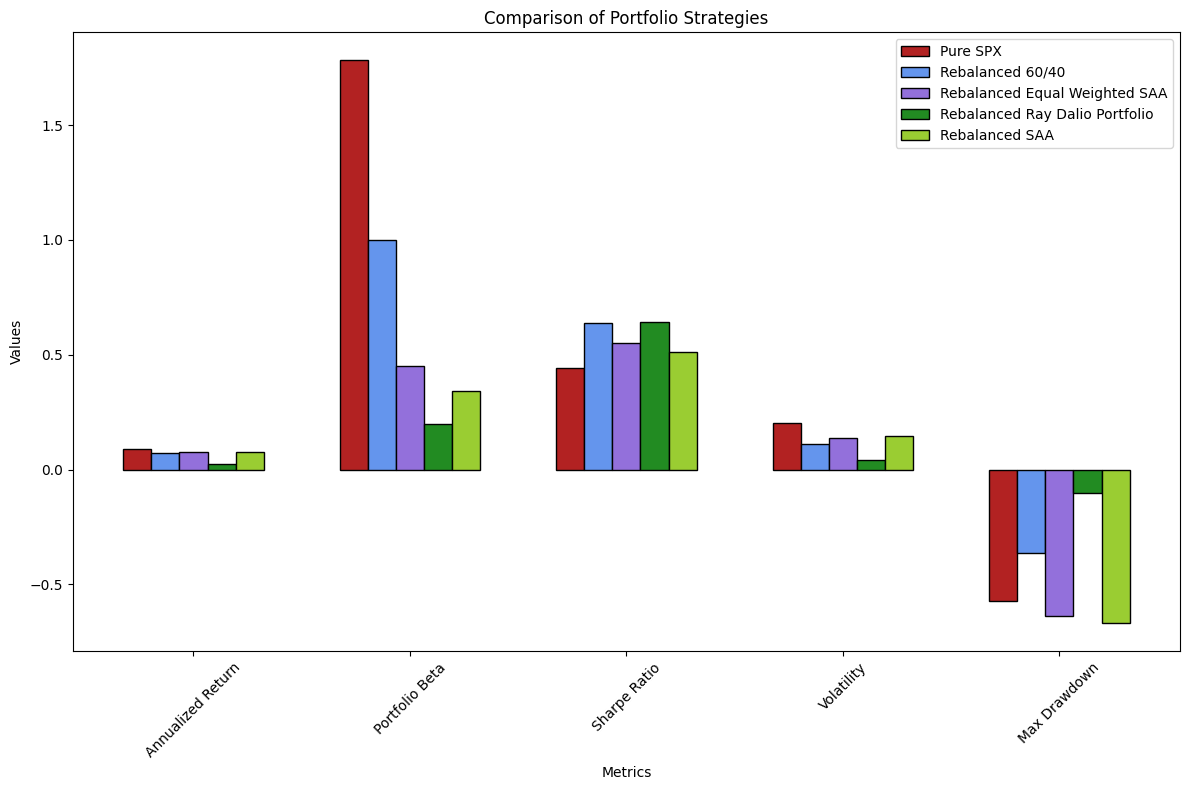

In [153]:
# Define the portfolio names
portfolios = ['Pure SPX', 'Rebalanced 60/40', 'Rebalanced Equal Weighted SAA', 'Rebalanced Ray Dalio Portfolio', 'Rebalanced SAA']

# Extract data for each portfolio
annualized_return = period_dfs['20 years']['Annualized Return']
portfolio_beta = period_dfs['20 years']['Portfolio Beta']
sharpe_ratio = period_dfs['20 years']['Sharpe Ratio']
volatility = period_dfs['20 years']['Volatility']
max_drawdown = period_dfs['20 years']['Max Drawdown']

# Define the categories
categories = ['Annualized Return', 'Portfolio Beta', 'Sharpe Ratio', 'Volatility', 'Max Drawdown']

# Define the number of categories and portfolios
num_categories = len(categories)
num_portfolios = len(portfolios)

# Define the width of the bars
bar_width = 0.13

# Define the index for the x-axis
index = range(num_categories)

# Define the colors for the bars
colors = ['firebrick', 'cornflowerblue', 'mediumpurple', 'forestgreen', 'yellowgreen']

# Plotting the clustered bar chart
plt.figure(figsize=(12, 8))

for i in range(num_portfolios):
    plt.bar([x + bar_width * i for x in index], period_dfs['20 years'].iloc[i], bar_width, label=portfolios[i], color=colors[i], edgecolor='black')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Portfolio Strategies')
plt.xticks([x + bar_width * 2 for x in index], categories)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

### Indicator to Change Portfolios

#### Setup

In [157]:
VIX_and_10_Year = pd.read_csv('VIX_and_TBill.csv')

In [158]:
VIX_and_10_Year

,Dates,VIX Index,GT10 Govt
0,7/28/2000,20.84,0.06034
1,7/31/2000,20.74,0.06031
2,8/1/2000,20.55,0.05984
3,8/2/2000,20.00,0.05976
4,8/3/2000,19.99,0.05952
...,...,...,...
5213,7/22/2020,24.32,0.00599
5214,7/23/2020,26.08,0.00579
5215,7/24/2020,25.84,0.00590
5216,7/27/2020,24.74,0.00616


In [159]:
print(VIX_and_10_Year.isnull().sum())

Dates        0
VIX Index    0
GT10 Govt    0
dtype: int64


In [160]:
VIX_and_10_Year.fillna(method='ffill', inplace=True)

In [161]:
VIX_and_10_Year = VIX_and_10_Year.drop_duplicates()


In [162]:
VIX_and_10_Year.columns

Index(['Dates', 'VIX Index', 'GT10 Govt'], dtype='object')

In [163]:
# Make sure 'Date' column is in datetime format
VIX_and_10_Year['Dates'] = pd.to_datetime(VIX_and_10_Year['Dates'])

# Sort dataframe by date in descending order
VIX_and_10_Year.sort_values(by='Dates', ascending=True, inplace=True)

VIX_and_10_Year = VIX_and_10_Year.rename(columns = {'GT10 Govt' : '10 Year TBill'})

In [164]:
VIX_and_10_Year

,Dates,VIX Index,10 Year TBill
0,2000-07-28,20.84,0.06034
1,2000-07-31,20.74,0.06031
2,2000-08-01,20.55,0.05984
3,2000-08-02,20.00,0.05976
4,2000-08-03,19.99,0.05952
...,...,...,...
5213,2020-07-22,24.32,0.00599
5214,2020-07-23,26.08,0.00579
5215,2020-07-24,25.84,0.00590
5216,2020-07-27,24.74,0.00616


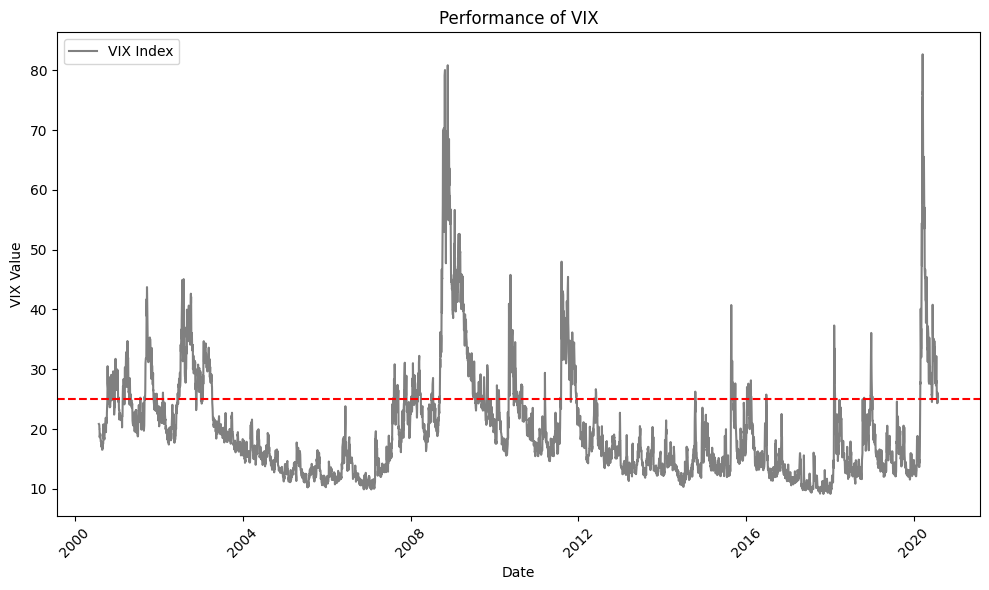

In [165]:
# Define the x-axis (dates)
dates = VIX_and_10_Year['Dates']

# Define the y-axis (portfolio values)
vix = VIX_and_10_Year['VIX Index']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, vix, label='VIX Index', color='gray')

plt.axhline(y = 25, color = 'r', linestyle = '--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.title('Performance of VIX')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

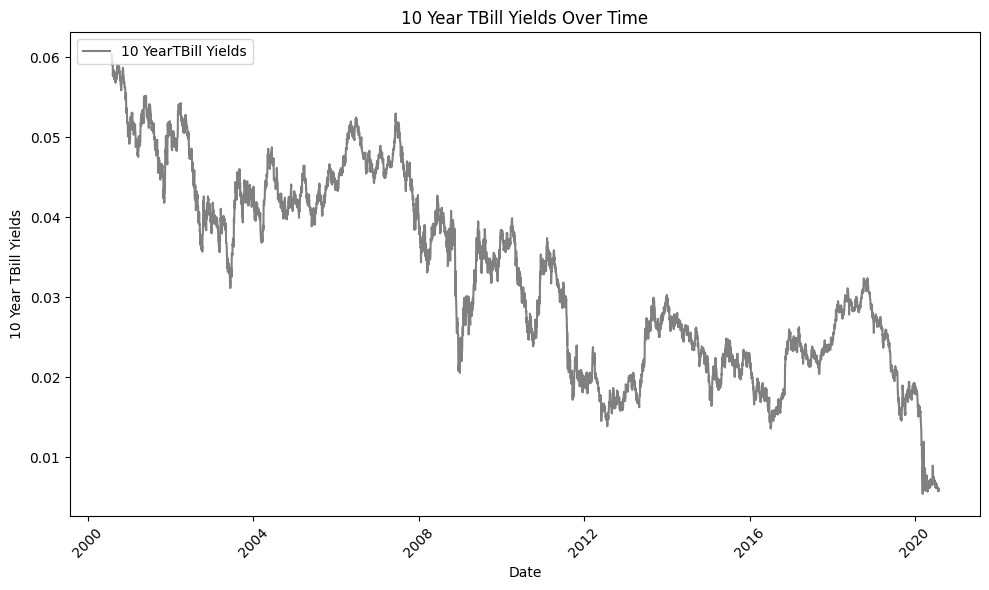

In [166]:
# Define the x-axis (dates)
dates = VIX_and_10_Year['Dates']

# Define the y-axis (portfolio values)
vix = VIX_and_10_Year['10 Year TBill']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, vix, label='10 YearTBill Yields', color='gray')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('10 Year TBill Yields')
plt.title('10 Year TBill Yields Over Time')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [167]:
myData = ['VIX Index', '10 Year TBill']

In [168]:
for data in myData:
  VIX_and_10_Year[data + " Daily Returns"] = VIX_and_10_Year[data].pct_change()

In [169]:
myData = ['VIX Index']

In [170]:
for data in myData:
  VIX_and_10_Year[data + ' 10_day_moving_average'] = VIX_and_10_Year[data].rolling(window=10).mean()

for data in myData:
  VIX_and_10_Year[data + ' 30_day_moving_average'] = VIX_and_10_Year[data].rolling(window=30).mean()

In [171]:
myData = ['10 Year TBill Daily Returns']

In [172]:
for data in myData:
  VIX_and_10_Year[data + ' 10_day_moving_average'] = VIX_and_10_Year[data].rolling(window=10).mean()

for data in myData:
  VIX_and_10_Year[data + ' 30_day_moving_average'] = VIX_and_10_Year[data].rolling(window=30).mean()

for data in myData:
  VIX_and_10_Year[data + ' 50_day_moving_average'] = VIX_and_10_Year[data].rolling(window=50).mean()

In [173]:
VIX_and_10_Year

,Dates,VIX Index,10 Year TBill,VIX Index Daily Returns,10 Year TBill Daily Returns,VIX Index 10_day_moving_average,VIX Index 30_day_moving_average,10 Year TBill Daily Returns 10_day_moving_average,10 Year TBill Daily Returns 30_day_moving_average,10 Year TBill Daily Returns 50_day_moving_average
0,2000-07-28,20.84,0.06034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-07-31,20.74,0.06031,-0.004798,-0.000497,NaN,NaN,NaN,NaN,NaN
2,2000-08-01,20.55,0.05984,-0.009161,-0.007793,NaN,NaN,NaN,NaN,NaN
3,2000-08-02,20.00,0.05976,-0.026764,-0.001337,NaN,NaN,NaN,NaN,NaN
4,2000-08-03,19.99,0.05952,-0.000500,-0.004016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5213,2020-07-22,24.32,0.00599,-0.020934,-0.004983,27.332,30.512333,-0.009836,-0.005795,-0.000556
5214,2020-07-23,26.08,0.00579,0.072368,-0.033389,27.014,30.022000,-0.005506,-0.004298,-0.000305
5215,2020-07-24,25.84,0.00590,-0.009202,0.018998,26.869,29.680333,-0.008818,-0.005354,-0.000600
5216,2020-07-27,24.74,0.00616,-0.042570,0.044068,26.124,29.358333,-0.000231,-0.004688,-0.002296


In [174]:
VIX_and_10_Year = VIX_and_10_Year.iloc[29:]
VIX_and_10_Year

,Dates,VIX Index,10 Year TBill,VIX Index Daily Returns,10 Year TBill Daily Returns,VIX Index 10_day_moving_average,VIX Index 30_day_moving_average,10 Year TBill Daily Returns 10_day_moving_average,10 Year TBill Daily Returns 30_day_moving_average,10 Year TBill Daily Returns 50_day_moving_average
29,2000-09-07,19.42,0.05752,-0.065897,0.004892,17.958,18.423667,0.000595,NaN,NaN
30,2000-09-08,18.46,0.05739,-0.049434,-0.002260,18.151,18.344333,0.000195,-0.001644,NaN
31,2000-09-11,18.40,0.05766,-0.003250,0.004705,18.337,18.266333,-0.000173,-0.001471,NaN
32,2000-09-12,18.59,0.05772,0.010326,0.001041,18.507,18.201000,-0.000605,-0.001176,NaN
33,2000-09-13,18.32,0.05724,-0.014524,-0.008316,18.570,18.145000,-0.001299,-0.001409,NaN
...,...,...,...,...,...,...,...,...,...,...
5213,2020-07-22,24.32,0.00599,-0.020934,-0.004983,27.332,30.512333,-0.009836,-0.005795,-0.000556
5214,2020-07-23,26.08,0.00579,0.072368,-0.033389,27.014,30.022000,-0.005506,-0.004298,-0.000305
5215,2020-07-24,25.84,0.00590,-0.009202,0.018998,26.869,29.680333,-0.008818,-0.005354,-0.000600
5216,2020-07-27,24.74,0.00616,-0.042570,0.044068,26.124,29.358333,-0.000231,-0.004688,-0.002296


In [175]:
VIX_and_10_Year.columns

Index(['Dates', 'VIX Index', '10 Year TBill', 'VIX Index Daily Returns',
       '10 Year TBill Daily Returns', 'VIX Index 10_day_moving_average',
       'VIX Index 30_day_moving_average',
       '10 Year TBill Daily Returns 10_day_moving_average',
       '10 Year TBill Daily Returns 30_day_moving_average',
       '10 Year TBill Daily Returns 50_day_moving_average'],
      dtype='object')

In [176]:
# Early 2000s Recession lenient timeframe
early_2000s_recession_start_date = '2000-01-01'
early_2000s_recession_end_date = '2003-01-01'

early_2000s_recession_time_period_slice = VIX_and_10_Year.loc[(VIX_and_10_Year['Dates'] >= early_2000s_recession_start_date) & (VIX_and_10_Year['Dates'] <= early_2000s_recession_end_date)]

In [177]:
# Great Recession lenient timeframe
great_recession_start_date = '2007-01-01'
great_recession_end_date = '2010-01-01'

great_recession_time_period_slice = VIX_and_10_Year.loc[(VIX_and_10_Year['Dates'] >= great_recession_start_date) & (VIX_and_10_Year['Dates'] <= great_recession_end_date)]

In [178]:
# COVID Recession lenient timeframe
covid_recession_start_date = '2019-01-01'
covid_recession_end_date = '2021-01-01'

covid_recession_time_period_slice = VIX_and_10_Year.loc[(VIX_and_10_Year['Dates'] >= covid_recession_start_date) & (VIX_and_10_Year['Dates'] <= covid_recession_end_date)]

#### VIX Trends

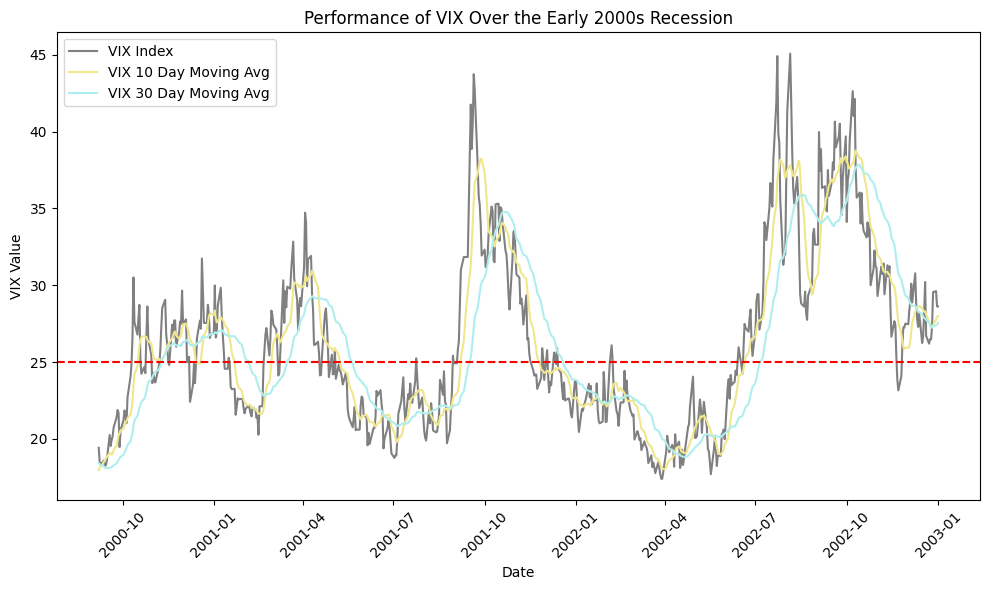

In [179]:
# Define the x-axis (dates)
dates = early_2000s_recession_time_period_slice['Dates']

# Define the y-axis (portfolio values)
vix = early_2000s_recession_time_period_slice['VIX Index']
vix_10_day_mov_avg = early_2000s_recession_time_period_slice['VIX Index 10_day_moving_average']
vix_30_day_mov_avg = early_2000s_recession_time_period_slice['VIX Index 30_day_moving_average']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, vix, label='VIX Index', color='gray')
plt.plot(dates, vix_10_day_mov_avg, label='VIX 10 Day Moving Avg', color='khaki')
plt.plot(dates, vix_30_day_mov_avg, label='VIX 30 Day Moving Avg', color='paleturquoise')

plt.axhline(y = 25, color = 'r', linestyle = '--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.title('Performance of VIX Over the Early 2000s Recession')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

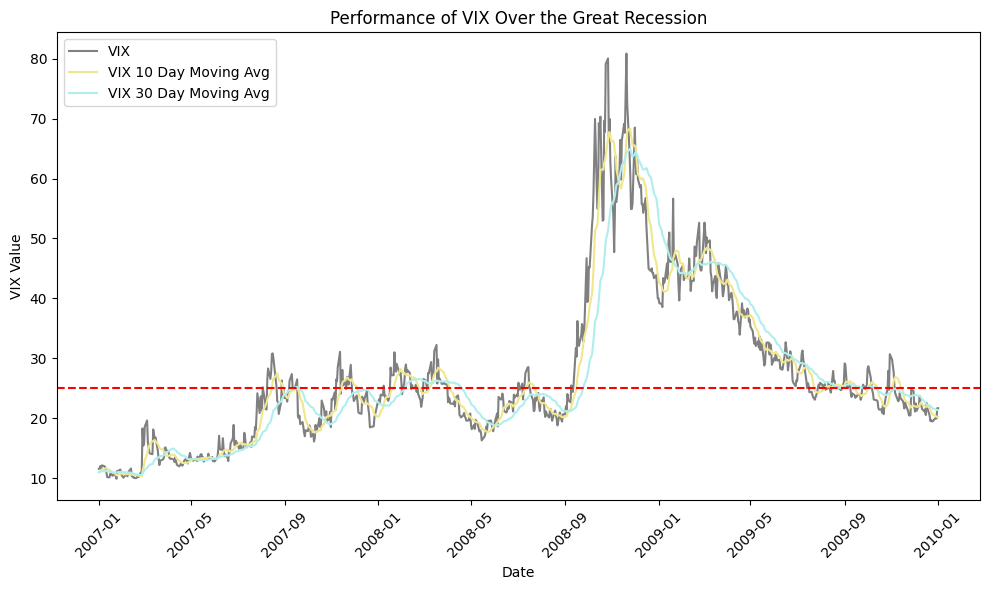

In [180]:
# Define the x-axis (dates)
dates = great_recession_time_period_slice['Dates']

# Define the y-axis (portfolio values)
vix = great_recession_time_period_slice['VIX Index']
vix_10_day_mov_avg = great_recession_time_period_slice['VIX Index 10_day_moving_average']
vix_30_day_mov_avg = great_recession_time_period_slice['VIX Index 30_day_moving_average']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, vix, label='VIX', color='gray')
plt.plot(dates, vix_10_day_mov_avg, label='VIX 10 Day Moving Avg', color='khaki')
plt.plot(dates, vix_30_day_mov_avg, label='VIX 30 Day Moving Avg', color='paleturquoise')

plt.axhline(y = 25, color = 'r', linestyle = '--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.title('Performance of VIX Over the Great Recession')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

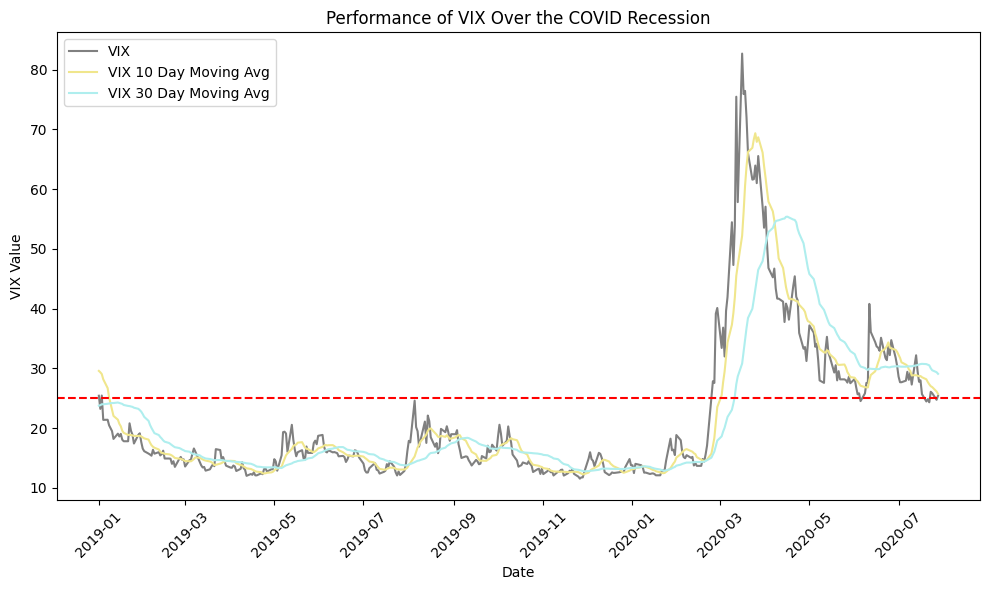

In [181]:
# Define the x-axis (dates)
dates = covid_recession_time_period_slice['Dates']

# Define the y-axis (portfolio values)
vix = covid_recession_time_period_slice['VIX Index']
vix_10_day_mov_avg = covid_recession_time_period_slice['VIX Index 10_day_moving_average']
vix_30_day_mov_avg = covid_recession_time_period_slice['VIX Index 30_day_moving_average']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, vix, label='VIX', color='gray')
plt.plot(dates, vix_10_day_mov_avg, label='VIX 10 Day Moving Avg', color='khaki')
plt.plot(dates, vix_30_day_mov_avg, label='VIX 30 Day Moving Avg', color='paleturquoise')

plt.axhline(y = 25, color = 'r', linestyle = '--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.title('Performance of VIX Over the COVID Recession')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 10 Year TBill Trends

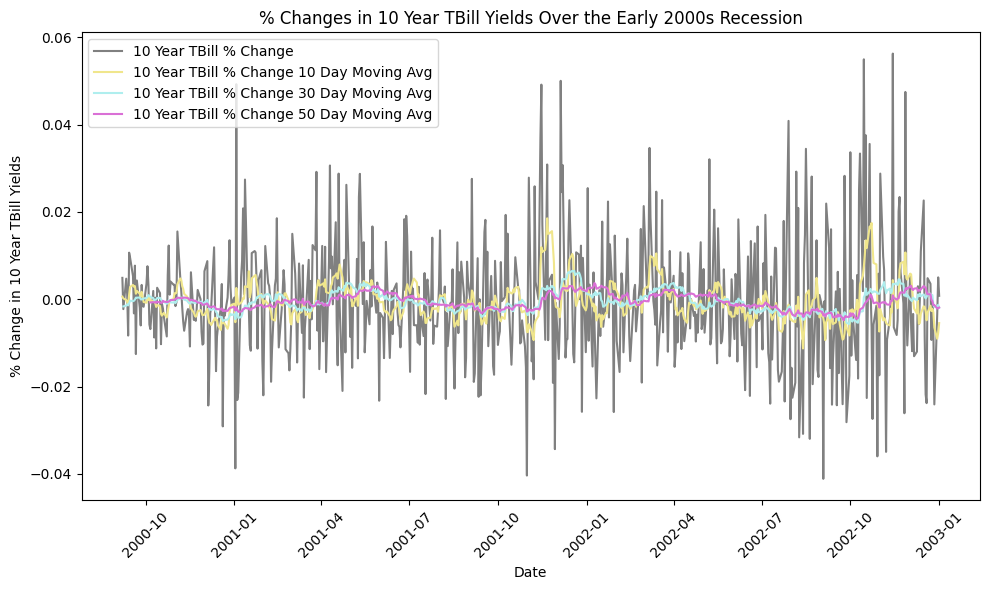

In [182]:
# Define the x-axis (dates)
dates = early_2000s_recession_time_period_slice['Dates']

# Define the y-axis (portfolio values)
treasury_10_year = early_2000s_recession_time_period_slice['10 Year TBill Daily Returns']
treasury_10_year_10_day_mov_avg = early_2000s_recession_time_period_slice['10 Year TBill Daily Returns 10_day_moving_average']
treasury_10_year_30_day_mov_avg = early_2000s_recession_time_period_slice['10 Year TBill Daily Returns 30_day_moving_average']
treasury_10_year_50_day_mov_avg = early_2000s_recession_time_period_slice['10 Year TBill Daily Returns 50_day_moving_average']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, treasury_10_year, label='10 Year TBill % Change', color='gray')
plt.plot(dates, treasury_10_year_10_day_mov_avg, label='10 Year TBill % Change 10 Day Moving Avg', color='khaki')
plt.plot(dates, treasury_10_year_30_day_mov_avg, label='10 Year TBill % Change 30 Day Moving Avg', color='paleturquoise')
plt.plot(dates, treasury_10_year_50_day_mov_avg, label='10 Year TBill % Change 50 Day Moving Avg', color='orchid')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('% Change in 10 Year TBill Yields')
plt.title('% Changes in 10 Year TBill Yields Over the Early 2000s Recession')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

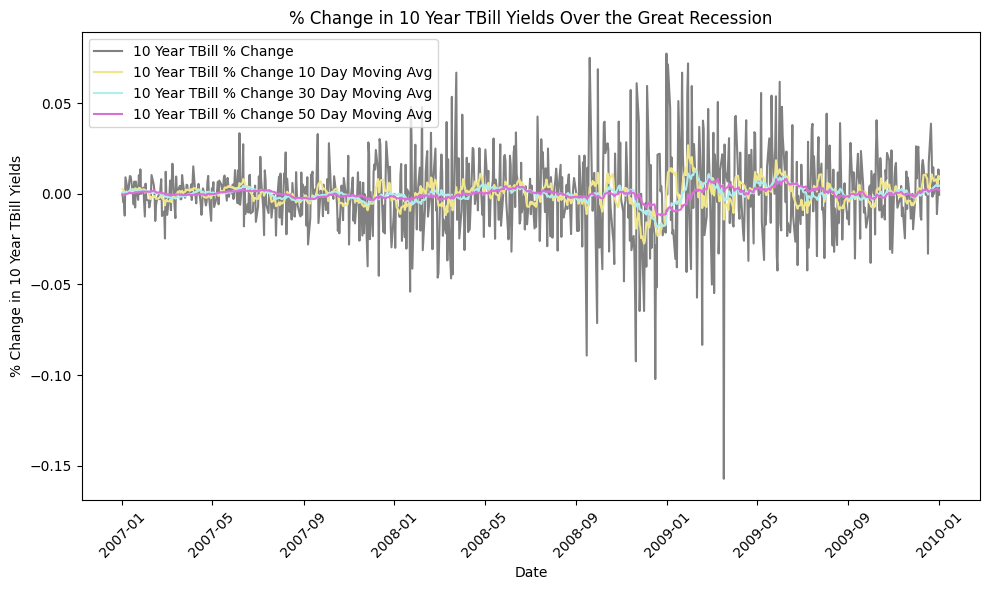

In [183]:
# Define the x-axis (dates)
dates = great_recession_time_period_slice['Dates']

# Define the y-axis (portfolio values)
treasury_10_year = great_recession_time_period_slice['10 Year TBill Daily Returns']
treasury_10_year_10_day_mov_avg = great_recession_time_period_slice['10 Year TBill Daily Returns 10_day_moving_average']
treasury_10_year_30_day_mov_avg = great_recession_time_period_slice['10 Year TBill Daily Returns 30_day_moving_average']
treasury_10_year_50_day_mov_avg = great_recession_time_period_slice['10 Year TBill Daily Returns 50_day_moving_average']


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, treasury_10_year, label='10 Year TBill % Change', color='gray')
plt.plot(dates, treasury_10_year_10_day_mov_avg, label='10 Year TBill % Change 10 Day Moving Avg', color='khaki')
plt.plot(dates, treasury_10_year_30_day_mov_avg, label='10 Year TBill % Change 30 Day Moving Avg', color='paleturquoise')
plt.plot(dates, treasury_10_year_50_day_mov_avg, label='10 Year TBill % Change 50 Day Moving Avg', color='orchid')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('% Change in 10 Year TBill Yields')
plt.title('% Change in 10 Year TBill Yields Over the Great Recession')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

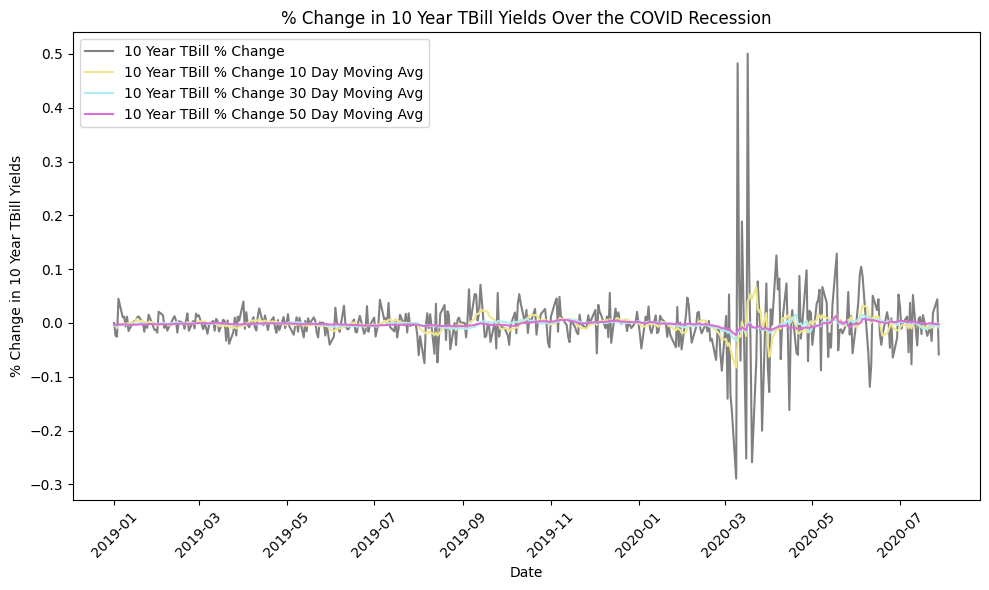

In [184]:
# Define the x-axis (dates)
dates = covid_recession_time_period_slice['Dates']

# Define the y-axis (portfolio values)
treasury_10_year = covid_recession_time_period_slice['10 Year TBill Daily Returns']
treasury_10_year_10_day_mov_avg = covid_recession_time_period_slice['10 Year TBill Daily Returns 10_day_moving_average']
treasury_10_year_30_day_mov_avg = covid_recession_time_period_slice['10 Year TBill Daily Returns 30_day_moving_average']
treasury_10_year_50_day_mov_avg = covid_recession_time_period_slice['10 Year TBill Daily Returns 50_day_moving_average']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, treasury_10_year, label='10 Year TBill % Change', color='gray')
plt.plot(dates, treasury_10_year_10_day_mov_avg, label='10 Year TBill % Change 10 Day Moving Avg', color='khaki')
plt.plot(dates, treasury_10_year_30_day_mov_avg, label='10 Year TBill % Change 30 Day Moving Avg', color='paleturquoise')
plt.plot(dates, treasury_10_year_50_day_mov_avg, label='10 Year TBill % Change 50 Day Moving Avg', color='orchid')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('% Change in 10 Year TBill Yields')
plt.title('% Change in 10 Year TBill Yields Over the COVID Recession')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Moving Forward With VIX Indicator

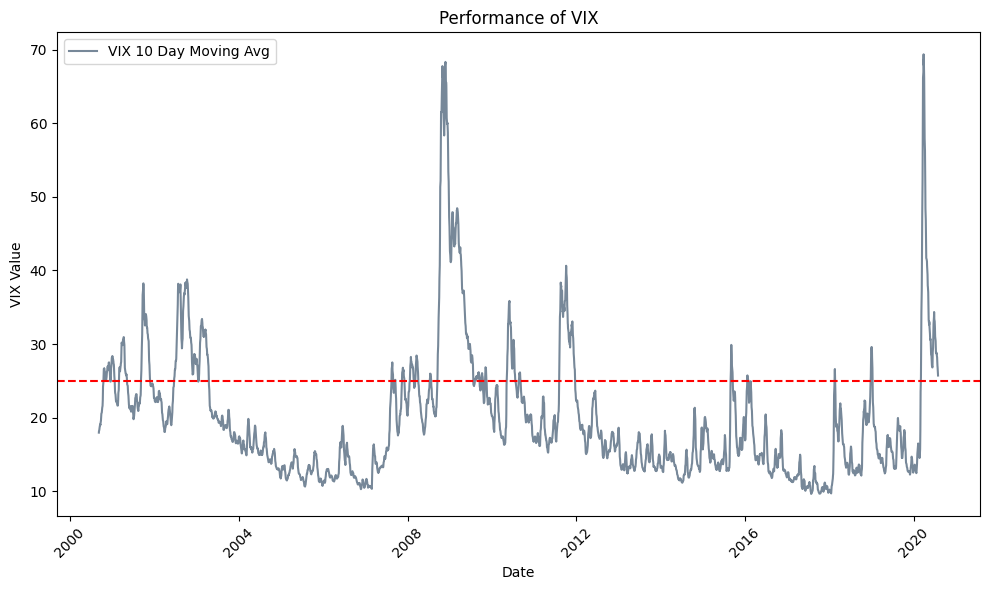

In [185]:
# Define the x-axis (dates)
dates = VIX_and_10_Year['Dates']

# Define the y-axis (portfolio values)
vix_10_day_mov_avg = VIX_and_10_Year['VIX Index 10_day_moving_average']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, vix_10_day_mov_avg, label='VIX 10 Day Moving Avg', color='lightslategrey')

plt.axhline(y = 25, color = 'r', linestyle = '--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.title('Performance of VIX')
plt.legend(loc = 'upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [186]:
VIX_DF = VIX_and_10_Year[['Dates', 'VIX Index', 'VIX Index 10_day_moving_average']]

In [187]:
VIX_DF

,Dates,VIX Index,VIX Index 10_day_moving_average
29,2000-09-07,19.42,17.958
30,2000-09-08,18.46,18.151
31,2000-09-11,18.40,18.337
32,2000-09-12,18.59,18.507
33,2000-09-13,18.32,18.570
...,...,...,...
5213,2020-07-22,24.32,27.332
5214,2020-07-23,26.08,27.014
5215,2020-07-24,25.84,26.869
5216,2020-07-27,24.74,26.124


In [188]:
VIX_DF['Strategy_B'] = 0

VIX_DF.loc[VIX_DF['VIX Index 10_day_moving_average'] > 25, 'Strategy_B'] = 1

VIX_DF

,Dates,VIX Index,VIX Index 10_day_moving_average,Strategy_B
29,2000-09-07,19.42,17.958,0
30,2000-09-08,18.46,18.151,0
31,2000-09-11,18.40,18.337,0
32,2000-09-12,18.59,18.507,0
33,2000-09-13,18.32,18.570,0
...,...,...,...,...
5213,2020-07-22,24.32,27.332,1
5214,2020-07-23,26.08,27.014,1
5215,2020-07-24,25.84,26.869,1
5216,2020-07-27,24.74,26.124,1


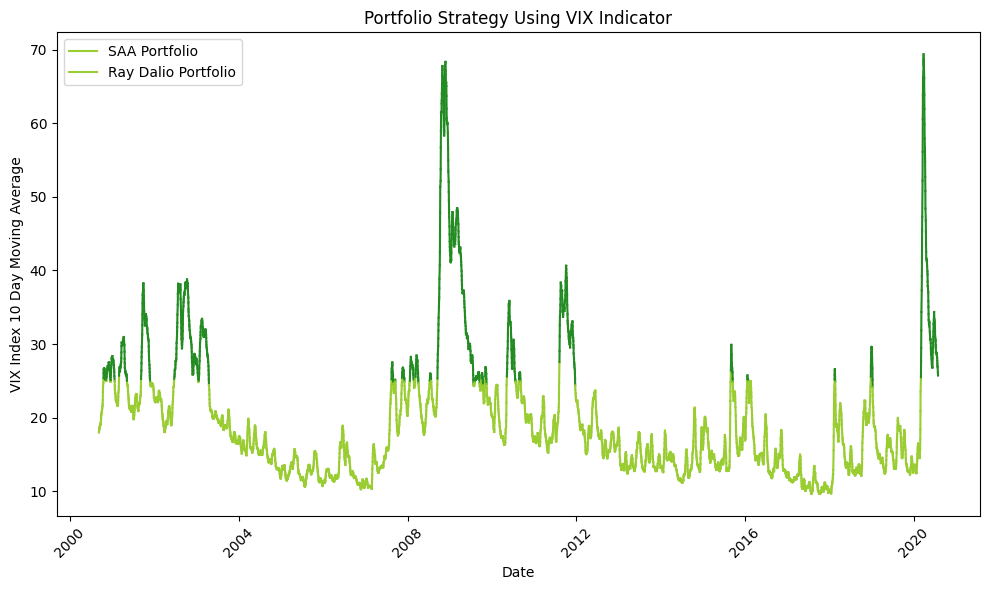

In [189]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate through each row and plot line segments based on 'Strategy_B'
for i in range(len(VIX_DF) - 1):
    if VIX_DF.loc[VIX_DF.index[i], 'Strategy_B'] == 0:
       plt.plot([VIX_DF.iloc[i]['Dates'], VIX_DF.iloc[i+1]['Dates']], [VIX_DF.iloc[i]['VIX Index 10_day_moving_average'], VIX_DF.iloc[i+1]['VIX Index 10_day_moving_average']],
                 color='yellowgreen', label='SAA Portfolio')
    else:
       plt.plot([VIX_DF.iloc[i]['Dates'], VIX_DF.iloc[i+1]['Dates']], [VIX_DF.iloc[i]['VIX Index 10_day_moving_average'], VIX_DF.iloc[i+1]['VIX Index 10_day_moving_average']],
                 color='forestgreen', label='Ray Dalio Portfolio')

# Labeling the axes and title
plt.xlabel('Date')
plt.ylabel('VIX Index 10 Day Moving Average')
plt.title('Portfolio Strategy Using VIX Indicator')

plt.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['SAA Portfolio', 'Ray Dalio Portfolio'], loc='upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Multi-Strategy Portfolio Allocation Using VIX

In [190]:
VIX_DF

,Dates,VIX Index,VIX Index 10_day_moving_average,Strategy_B
29,2000-09-07,19.42,17.958,0
30,2000-09-08,18.46,18.151,0
31,2000-09-11,18.40,18.337,0
32,2000-09-12,18.59,18.507,0
33,2000-09-13,18.32,18.570,0
...,...,...,...,...
5213,2020-07-22,24.32,27.332,1
5214,2020-07-23,26.08,27.014,1
5215,2020-07-24,25.84,26.869,1
5216,2020-07-27,24.74,26.124,1


#### Visualizing When Strategy Swap Would Occur

In [191]:
strategy_visualization_data = Complete_Portfolio_Performance[['Date', 'Rebalanced SAA Portfolio Value']]

In [192]:
strategy_visualization_data = strategy_visualization_data.rename(columns = {'Date' : 'Dates'})

In [193]:
VIX_DF = VIX_DF.loc[(VIX_DF['Dates'] >= '2001-05-31')]

In [194]:
VIX_DF

,Dates,VIX Index,VIX Index 10_day_moving_average,Strategy_B
219,2001-05-31,22.64,21.473,0
220,2001-06-01,21.59,21.509,0
221,2001-06-04,21.38,21.571,0
222,2001-06-05,19.58,21.394,0
223,2001-06-06,20.39,21.225,0
...,...,...,...,...
5213,2020-07-22,24.32,27.332,1
5214,2020-07-23,26.08,27.014,1
5215,2020-07-24,25.84,26.869,1
5216,2020-07-27,24.74,26.124,1


In [195]:
strategy_visualization_data = pd.merge(VIX_DF, strategy_visualization_data, on=['Dates','Dates']).sort_index(axis=1)
strategy_visualization_data

,Dates,Rebalanced SAA Portfolio Value,Strategy_B,VIX Index,VIX Index 10_day_moving_average
0,2001-05-31,131.545187,0,22.64,21.473
1,2001-06-01,132.161317,0,21.59,21.509
2,2001-06-04,132.795326,0,21.38,21.571
3,2001-06-05,133.153480,0,19.58,21.394
4,2001-06-06,133.892290,0,20.39,21.225
...,...,...,...,...,...
4994,2020-07-22,469.718359,1,24.32,27.332
4995,2020-07-23,469.459935,1,26.08,27.014
4996,2020-07-24,465.477858,1,25.84,26.869
4997,2020-07-27,463.779462,1,24.74,26.124


In [196]:
print(strategy_visualization_data.isnull().sum())

Dates                              0
Rebalanced SAA Portfolio Value     0
Strategy_B                         0
VIX Index                          0
VIX Index 10_day_moving_average    0
dtype: int64


In [197]:
strategy_visualization_data = strategy_visualization_data[['Dates', 'Rebalanced SAA Portfolio Value', 'Strategy_B']]
strategy_visualization_data

,Dates,Rebalanced SAA Portfolio Value,Strategy_B
0,2001-05-31,131.545187,0
1,2001-06-01,132.161317,0
2,2001-06-04,132.795326,0
3,2001-06-05,133.153480,0
4,2001-06-06,133.892290,0
...,...,...,...
4994,2020-07-22,469.718359,1
4995,2020-07-23,469.459935,1
4996,2020-07-24,465.477858,1
4997,2020-07-27,463.779462,1


In [198]:
strategy_visualization_data.columns

Index(['Dates', 'Rebalanced SAA Portfolio Value', 'Strategy_B'], dtype='object')

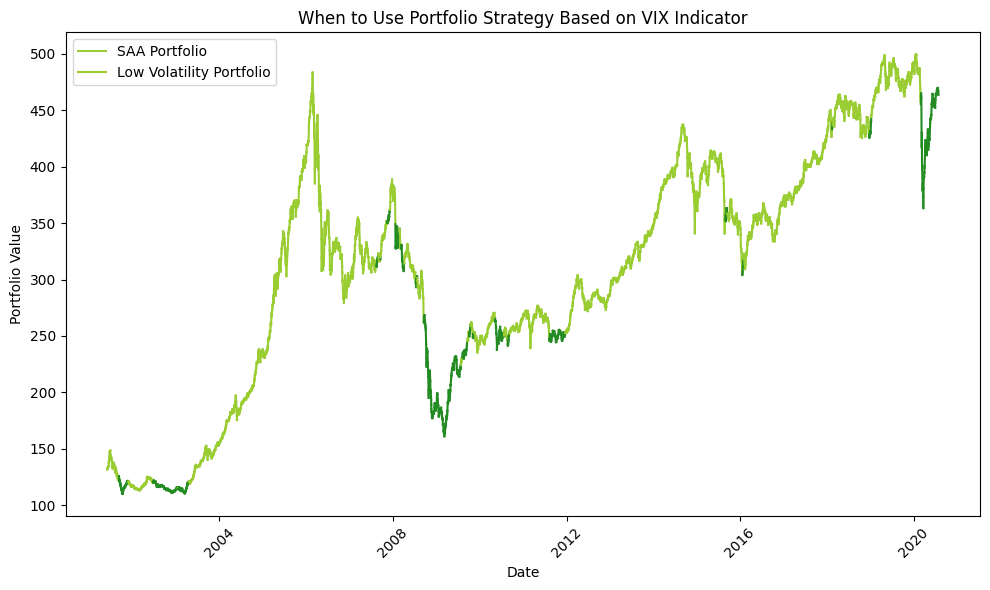

In [199]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate through each row and plot line segments based on 'Strategy_B'
for i in range(len(strategy_visualization_data) - 1):
    if strategy_visualization_data.loc[strategy_visualization_data.index[i], 'Strategy_B'] == 0:
        plt.plot([strategy_visualization_data.iloc[i]['Dates'], strategy_visualization_data.iloc[i+1]['Dates']],
                 [strategy_visualization_data.iloc[i]['Rebalanced SAA Portfolio Value'], strategy_visualization_data.iloc[i+1]['Rebalanced SAA Portfolio Value']],
                 color='yellowgreen', label='SAA Portfolio')
    else:
        plt.plot([strategy_visualization_data.iloc[i]['Dates'], strategy_visualization_data.iloc[i+1]['Dates']],
                 [strategy_visualization_data.iloc[i]['Rebalanced SAA Portfolio Value'], strategy_visualization_data.iloc[i+1]['Rebalanced SAA Portfolio Value']],
                 color='forestgreen', label='Ray Dalio Portfolio')

# Labeling the axes and title
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('When to Use Portfolio Strategy Based on VIX Indicator')

plt.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['SAA Portfolio', 'Low Volatility Portfolio'], loc='upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
